# Federated Learning Implementation with tensorflow



In [81]:
# """
# Adult Dataset Salary Prediction 
# This is part of a study to investigate Differetinal privacy in Machine learning, Naturally we wish to compare it with federated learning.



# Refrences:

# [1] Federated Learning with Non-IID Data, Yue Zhao et al, arXiv: 1806.00582v1, 2 Jun 2018
# [2] Communication-Efficient Learning of Deep Networks from Decentralized Data, H. Brendan McMahan et al, arXiv:1602.05629v3 [cs.LG] 28 Feb 2017

# """

In [82]:
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from sklearn.metrics import precision_score,recall_score, accuracy_score,confusion_matrix,f1_score
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import optimizers


import pandas as pd



In [83]:
# file_out = pd.read_csv('adult_processed1.csv')
# cols = []
# for i in list(file_out.columns):
#     if  i != 'income':
#         cols.append(i)
# feature_set1 = pd.read_csv('train1.csv')
# feature_set2 = pd.read_csv('test1.csv')



# x = feature_set1[cols].copy().values
# y = feature_set1[['income']].copy().values
        
# sc = StandardScaler()
# X_train = sc.fit_transform(x)
# y_train = y


# x2 = feature_set2[cols].copy().values
# y2 = feature_set2[['income']].copy().values


# X_test = sc.transform(x2)
# y_test = y2

In [84]:

def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 




In [85]:
### Train/Test Data seperation

file_out = pd.read_csv('adult_processed2.csv')
cols = []
for i in list(file_out.columns):
    if  i != 'income':
        cols.append(i)

feature_set1 = pd.read_csv('train1.csv')
feature_set2 = pd.read_csv('test1.csv')
testdata = pd.read_csv('test1.csv')

feature_set1=feature_set1.drop(['gender'],axis=1)
feature_set2=feature_set2.drop(['gender'],axis=1)
x = feature_set1[cols].copy().values
y = feature_set1[['income']].copy().values
        
sc = StandardScaler()
X_train = sc.fit_transform(x)
y_train = y

x2 = feature_set2[cols].copy().values
y2 = feature_set2[['income']].copy().values
        
X_test = sc.transform(x2)
y_test = y2



X_test.shape, y_test.shape 
X_test

array([[ 0.69954745, -0.41287946, -0.39466557, ...,  0.33728629,
        -0.04175364, -0.02024   ],
       [-0.11372927, -0.33997008, -1.4243511 , ...,  0.33728629,
        -0.04175364, -0.02024   ],
       [ 0.54923255, -1.14197323,  0.03945613, ...,  0.33728629,
        -0.04175364, -0.02024   ],
       ...,
       [-0.86977699, -0.48578884,  0.08998404, ...,  0.33728629,
        -0.04175364, -0.02024   ],
       [-0.21611665,  0.75367057, -0.29233586, ...,  0.33728629,
        -0.04175364, -0.02024   ],
       [-1.07724989, -0.48578884,  1.01818596, ...,  0.33728629,
        -0.04175364, -0.02024   ]])

In [86]:
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    
    return dataset.shuffle(len(label)).batch(bs)

In [87]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes=2 , learning_rate = 0.001, metric = "accuracy"):

        model = Sequential()
        
        model.add(Dense(128, input_shape = (shape,)))
#         model.add(Dense(128, Activation("relu")))
#         model.add(Dense(64, Activation("relu")))
#         model.add(Dense(32, Activation("relu")))
#         model.add(Dense(1))
        
        model.add(Dense(128, Activation("relu")))
        model.add(Dense(64, Activation("relu")))
        model.add(Dense(32, Activation("relu")))
        model.add(Dense(1,Activation('sigmoid')))
        


        return model

In [88]:
lr = 0.5
comms_round = 10
loss=tf.keras.losses.BinaryCrossentropy(from_logits = False)

metrics = ['binary_accuracy']

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.5
               )

     



In [89]:


x_data=[]
y_data=[]
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
#     print(len(scaled_weight_list))
    for grad_list_tuple in zip(*scaled_weight_list):
#         print(len(grad_list_tuple))
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    
#     cce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#     cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    logits = model.predict(X_test)

    score = global_model.evaluate(X_test, y_test, verbose=0)
    acc = score[1] ; loss = score[0]
    x_data.append(comm_round+1)
    y_data.append(acc)
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))

    return acc, loss

In [90]:
def federated_learning(comms_round,clients_batched,test_batched,global_model):       
    #commence global training loop
    for comm_round in range(comms_round):
                
        # get the global model's weights - will serve as the initial weights for all local models
        global_weights = global_model.get_weights()
        
        #initial list to collect local model weights after scalling
        scaled_local_weight_list = list()

        #randomize client data - using keys
        client_names= list(clients_batched.keys())
        random.shuffle(client_names)
        
        #loop through each client and create new local model
        for client in client_names:
            smlp_local = SimpleMLP()
            local_model = smlp_local.build(X_train.shape[1],classes=2)
            local_model.compile(loss=loss, 
                        optimizer=optimizer, 
                        metrics=metrics)
            
            #set local model weight to the weight of the global model
            local_model.set_weights(global_weights)
            
            #fit local model with client's data
            local_model.fit(clients_batched[client], epochs=1, verbose=1)
            
            #scale the model weights and add to list
            scaling_factor = weight_scalling_factor(clients_batched, client)
            scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
            scaled_local_weight_list.append(scaled_weights)
            
            #clear session to free memory after each communication round
            K.clear_session()
            
        #to get the average over all the local model, we simply take the sum of the scaled weights
        average_weights = sum_scaled_weights(scaled_local_weight_list)
        
        #update global model 
        global_model.set_weights(average_weights)

    #     test global model and print out metrics after each communications round
        for(X_test, Y_test) in test_batched:
            global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

            

    
    return global_acc

In [91]:

#initialize global model

lr = 0.05

loss=tf.keras.losses.BinaryCrossentropy(from_logits = False)

metrics = ['binary_accuracy']

comms_round = 10   




num_client=[2]
acc_score=[]
fairness_score=[]
fairness_score1=[]
for num_clients in num_client:
    comms_round = 20
    comms_round=comms_round
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.5
               )
    smlp_global = SimpleMLP()
    global_model = smlp_global.build(X_train.shape[1] ,classes=2)
    global_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 

    clients = create_clients(X_train, y_train, num_clients, initial='client')
    print(clients.keys())
    #process and batch the training data for each client
    clients_batched = dict()
    for (client_name, data) in clients.items():
        clients_batched[client_name] = batch_data(data)
        
    #process and batch the test set  
    test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))
    test_batched

    temp=federated_learning(comms_round,clients_batched,test_batched,global_model)
    acc_score.append(temp)
    from fairlearn.metrics import demographic_parity_ratio,demographic_parity_difference
    
    nn_preds = global_model.predict(X_test)
    nn_preds = (nn_preds > 0.5)

    

    sf_data=testdata['gender']
    

    fairness_score.append(demographic_parity_ratio(y_test,
                               nn_preds,
                               sensitive_features=sf_data))
    fairness_score1.append(demographic_parity_difference(y_test,
                               nn_preds,
                               sensitive_features=sf_data))
    



dict_keys(['client_1', 'client_2'])
306/306 [==============================] - 0s 595us/step
comm_round: 0 | global_acc: 84.900% | global_loss: 0.3289589285850525
306/306 [==============================] - 0s 605us/step
comm_round: 1 | global_acc: 85.186% | global_loss: 0.3226000666618347
306/306 [==============================] - 0s 601us/step
comm_round: 2 | global_acc: 85.309% | global_loss: 0.3198005259037018
306/306 [==============================] - 0s 609us/step
comm_round: 3 | global_acc: 85.422% | global_loss: 0.31764936447143555
306/306 [==============================] - 0s 650us/step
comm_round: 4 | global_acc: 85.452% | global_loss: 0.3157210648059845
306/306 [==============================] - 0s 611us/step
comm_round: 5 | global_acc: 85.514% | global_loss: 0.31546396017074585
306/306 [==============================] - 0s 621us/step
comm_round: 6 | global_acc: 85.463% | global_loss: 0.3147547245025635
306/306 [==============================] - 0s 622us/step
comm_round: 7 | 

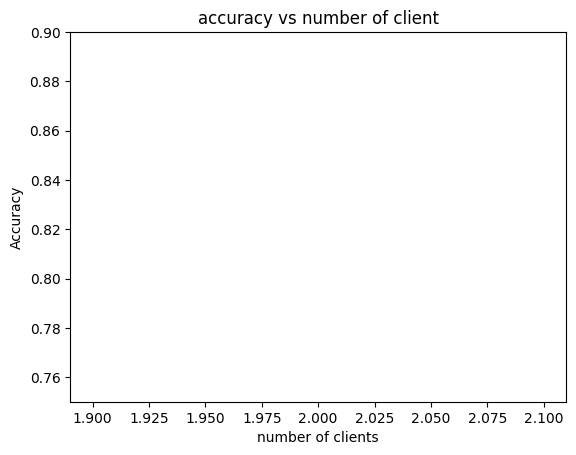

In [92]:
import matplotlib.pyplot as plt



  
  
# plotting the points 
plt.ylim(.75,.9)
plt.plot(num_client, acc_score)
  
# naming the x axis
plt.xlabel('number of clients')
# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('accuracy vs number of client')
  
# function to show the plot
plt.show()

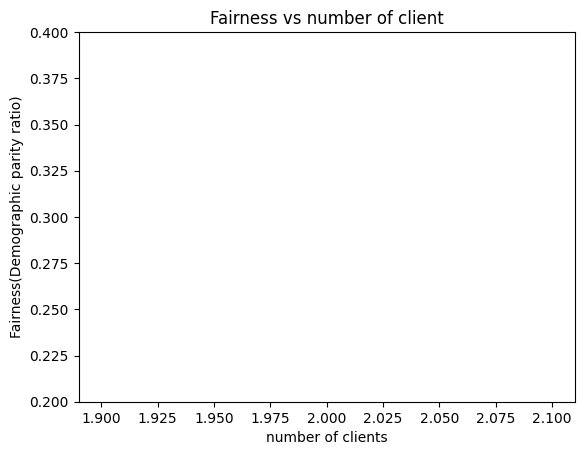

In [93]:

plt.plot(num_client, fairness_score)
plt.ylim(0.2,.4)  
# naming the x axis
plt.xlabel('number of clients')
# naming the y axis
plt.ylabel('Fairness(Demographic parity ratio)')
  
# giving a title to my graph
plt.title('Fairness vs number of client')
  
# function to show the plot
plt.show()

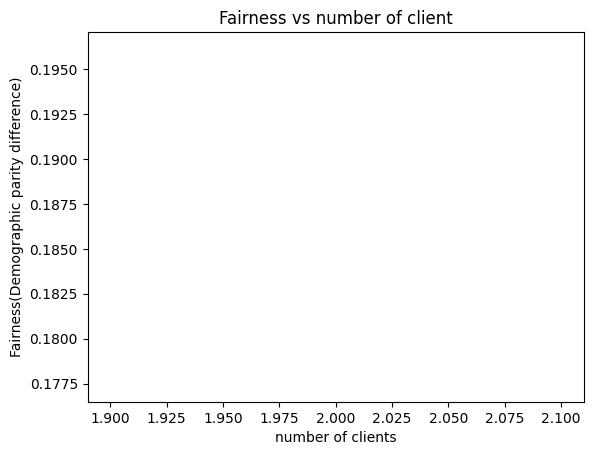

In [94]:

plt.plot(num_client, fairness_score1)
  
# naming the x axis
plt.xlabel('number of clients')
# naming the y axis
plt.ylabel('Fairness(Demographic parity difference)')
  
# giving a title to my graph
plt.title('Fairness vs number of client')
  
# function to show the plot
plt.show()

In [95]:
import matplotlib as plt
def eval_performance(results_df):
    summaries = {}
    #accuracy for different gender
    rows = results_df[results_df.gender==0]
    accuracy_for_female = rows.accurate.mean()
    
    rows1 = rows[results_df.pred==1]
    positive_rate_female=rows1.accurate.mean();
    
    summaries['Female_accuracy']=accuracy_for_female
    summaries['Female_Positive_Rate']=positive_rate_female
    

    rows = results_df[results_df.gender==1]
    accuracy_for_male = rows.accurate.mean();
    
    rows1 = rows[results_df.pred==1]
    positive_rate_male=rows1.accurate.mean();

    summaries['Male_accuracy']=accuracy_for_male
    summaries['Male_Positive_Rate']=positive_rate_male



    return summaries


def evaluate_predictor_performance(predictions, x_test, y_test):

    testdata = pd.read_csv('test1.csv')
    testdata['salary'] = y_test
    testdata['pred'] = predictions
    print(testdata)
    testdata['accurate'] = (testdata['pred'] == testdata['salary'])
    sf_data=testdata['gender']
    return eval_performance(testdata)



In [96]:
nn_preds = global_model.predict(X_test)
nn_preds = (nn_preds > 0.5)
print(nn_preds)

evaluate_predictor_performance(nn_preds, X_test, y_test)




306/306 [==============================] - 0s 584us/step
[[False]
 [False]
 [False]
 ...
 [False]
 [ True]
 [False]]
      Unnamed: 0  age  fnlwgt  education  educational-num  capital-gain   
0          34314   33  147921       11.0                9             0  \
1          22860   34   39609        8.0               11             0   
2          32197   23  193586       15.0               10             0   
3          12733   36   23892        7.0               12             0   
4          41982   31  106347       15.0               10             0   
...          ...  ...     ...        ...              ...           ...   
9763       22247   45  242552        2.0                8             0   
9764        4829   42  198028       15.0               10             0   
9765       12212   32  198901        0.0                6             0   
9766       21418   49  158685       11.0                9             0   
9767        9290   32  296538       11.0                9 

C:\Users\sachi\AppData\Local\Temp\ipykernel_4256\3066740539.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rows1 = rows[results_df.pred==1]
C:\Users\sachi\AppData\Local\Temp\ipykernel_4256\3066740539.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rows1 = rows[results_df.pred==1]


{'Female_accuracy': 0.9270735524256651,
 'Female_Positive_Rate': 0.7126865671641791,
 'Male_accuracy': 0.8213905370454891,
 'Male_Positive_Rate': 0.7492973580663294}

In [97]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(100)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(X_train.shape[1], 2) 

SGD_model.compile(loss=loss, 
              optimizer=optimizer)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=20, verbose=0)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)



metrices={}
nn_preds = SGD_model.predict(X_test)

# approach_2_blind = evaluate_predictor_performance(global_model.predict(X_test, y_test))
# model_summary("MLP, equal_datapoints_blind", "", approach_2_blind)

nn_preds = (nn_preds > 0.5)

testdata = pd.read_csv('test1.csv')

sf_data=testdata['gender']


from fairlearn.metrics import selection_rate
from fairlearn.metrics import demographic_parity_difference,equalized_odds_difference
print(demographic_parity_difference(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
print(demographic_parity_ratio(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,recall_score

print(equalized_odds_difference(y_test,
                                nn_preds,
                                sensitive_features=sf_data))


306/306 [==============================] - 0s 646us/step
comm_round: 1 | global_acc: 85.596% | global_loss: 0.311939537525177
306/306 [==============================] - 0s 664us/step
0.18293802574052764
0.3029265836565286
0.09998783500916564


306/306 [==============================] - 0s 616us/step
0.18677160585093805
0.30992143605496575
0.09634113430849023
0.855958230958231
gender
False    0.927074
True     0.821391
Name: accuracy_score, dtype: float64
0.7445041524181729
gender
False    0.712687
True     0.749297
Name: precision_score, dtype: float64
0.20956183456183455
gender
False    0.083881
True     0.270653
Name: selection_rate, dtype: float64
0.632890365448505


array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'recall'}, xlabel='Gender'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>]], dtype=object)

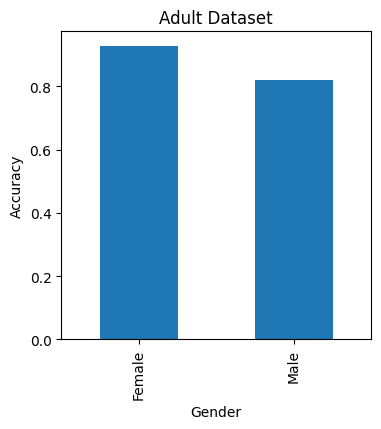

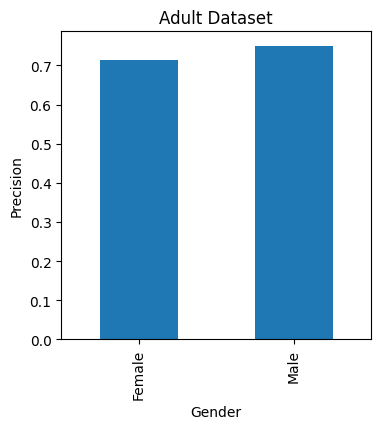

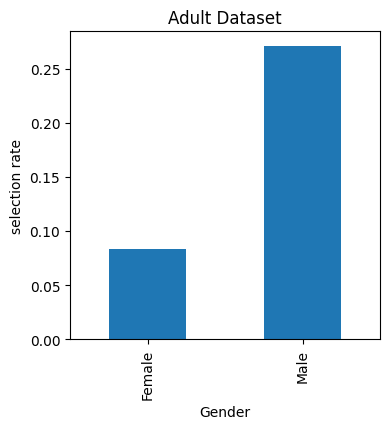

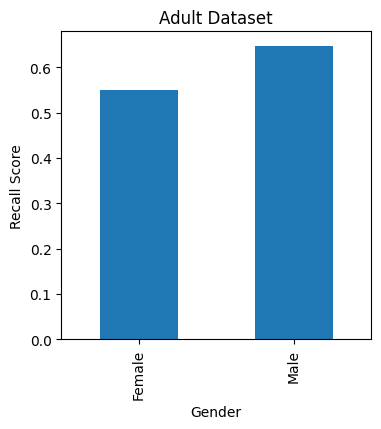

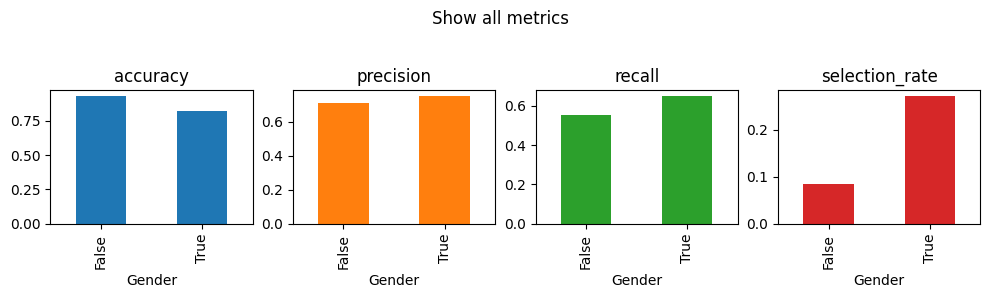

In [98]:
metrices={}
nn_preds = global_model.predict(X_test)

# approach_2_blind = evaluate_predictor_performance(global_model.predict(X_test, y_test))
# model_summary("MLP, equal_datapoints_blind", "", approach_2_blind)

nn_preds = (nn_preds > 0.5)

testdata = pd.read_csv('test1.csv')

sf_data=testdata['gender']


from fairlearn.metrics import selection_rate
from fairlearn.metrics import demographic_parity_difference,equalized_odds_difference
print(demographic_parity_difference(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
print(demographic_parity_ratio(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,recall_score

print(equalized_odds_difference(y_test,
                                nn_preds,
                                sensitive_features=sf_data))

gm = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm.overall)
print(gm.by_group)

t=gm.by_group
m=list(t)




m=pd.DataFrame(m,['Female','Male'])
m.plot.bar(
    subplots=False,
    
    layout=[4, 4],
    legend=False,
    figsize=[4, 4],
    title="Adult Dataset",
    ylabel="Accuracy",
    xlabel='Gender',
)


gm1 = MetricFrame(metrics=precision_score, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm1.overall)
print(gm1.by_group)
t=gm1.by_group
m=list(t)




m=pd.DataFrame(m,['Female','Male'])
m.plot.bar(
    subplots=False,
    
    layout=[4, 4],
    legend=False,
    figsize=[4, 4],
    title="Adult Dataset",
    ylabel="Precision",
    xlabel='Gender',
)

gm2 = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm2.overall)
print(gm2.by_group)

t=gm2.by_group
m=list(t)




m=pd.DataFrame(m,['Female','Male'])
m.plot.bar(
    subplots=False,
    
    layout=[4, 4],
    legend=False,
    figsize=[4, 4],
    title="Adult Dataset",
    ylabel="selection rate",
    xlabel='Gender',
)

gm3 = MetricFrame(metrics=recall_score, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm3.overall)
t=gm3.by_group
m=list(t)




m=pd.DataFrame(m,['Female','Male'])
m.plot.bar(
    subplots=False,
    
    layout=[4, 4],
    legend=False,
    figsize=[4, 4],
    title="Adult Dataset",
    ylabel="Recall Score",
    xlabel='Gender',
)


 
tick_label = {0:'Male',1:'Female'}

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
    
}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=nn_preds,
                           sensitive_features=sf_data)

M=metric_frame.by_group
M.plot.bar(
    subplots=True,
    
    layout=[4, 4],
    legend=False,
    figsize=[12, 8],
   
    title="Show all metrics",
    
    xlabel='Gender',
)











# nn_precision =precision_score(y_test, nn_preds)
# nn_recall = recall_score(y_test, nn_preds)
# nn_accuracy = accuracy_score(y_test, nn_preds)
# nn_f1 = f1_score(y_test, nn_preds)

# metrices['Accuracy']=(nn_accuracy)

# metrices['Precision']=nn_precision
# metrices['Recall']=nn_recall
# metrices['f1']=nn_f1
# print("Precision = {}".format(nn_precision))
# print("Recall = {}".format(nn_recall))
# print("Accuracy = {}".format(nn_accuracy))
# print("f1 = {}".format(nn_f1))



  
# fig = plt.figure(figsize = (10, 5))
 
# # creating the bar plot
# plt.bar(courses, values, color ='maroon',
#         width = 0.4)
 
# plt.xlabel("Courses offered")
# plt.ylabel("No. of students enrolled")
# plt.title("Students enrolled in different courses")
# plt.show()

c:\Users\sachi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.871007371007371
gender
False    0.938967
True     0.837974
Name: accuracy_score, dtype: float64
0.17057202997895074
0.29129585774232414
0.871007371007371
gender
False    0.938967
True     0.837974
Name: accuracy_score, dtype: float64
0.8178294573643411
gender
False    0.839286
True     0.814791
Name: precision_score, dtype: float64
0.18488943488943488
gender
False    0.070110
True     0.240682
Name: selection_rate, dtype: float64


NameError: name 'y_pred' is not defined

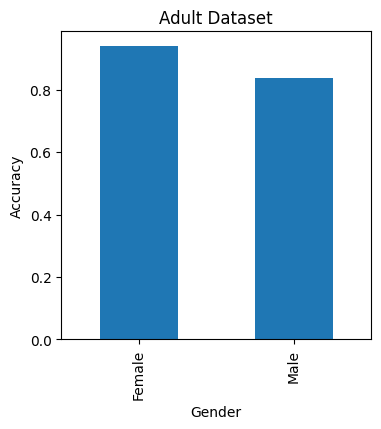

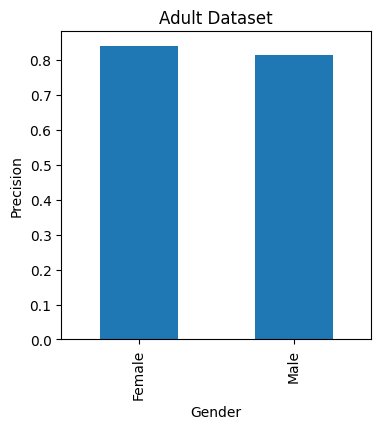

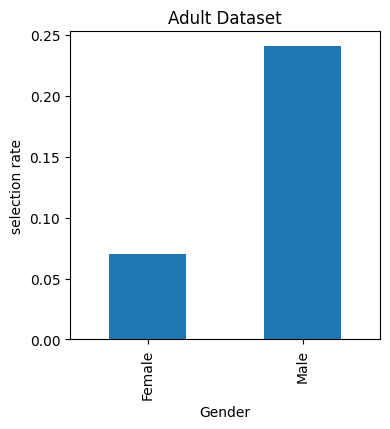

In [99]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)

nn_preds = classifier.predict(X_test)








gm = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm.overall)
print(gm.by_group)
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}

print(demographic_parity_difference(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
print(demographic_parity_ratio(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,recall_score

# print(equalized_odds_difference(y_test,
#                                 nn_preds,
#                                 sensitive_features=sf_data))

gm = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm.overall)
print(gm.by_group)

t=gm.by_group
m=list(t)




m=pd.DataFrame(m,['Female','Male'])
m.plot.bar(
    subplots=False,
    
    layout=[4, 4],
    legend=False,
    figsize=[4, 4],
    title="Adult Dataset",
    ylabel="Accuracy",
    xlabel='Gender',
)


gm1 = MetricFrame(metrics=precision_score, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm1.overall)
print(gm1.by_group)
t=gm1.by_group
m=list(t)




m=pd.DataFrame(m,['Female','Male'])
m.plot.bar(
    subplots=False,
    
    layout=[4, 4],
    legend=False,
    figsize=[4, 4],
    title="Adult Dataset",
    ylabel="Precision",
    xlabel='Gender',
)

gm2 = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm2.overall)
print(gm2.by_group)

t=gm2.by_group
m=list(t)




m=pd.DataFrame(m,['Female','Male'])
m.plot.bar(
    subplots=False,
    
    layout=[4, 4],
    legend=False,
    figsize=[4, 4],
    title="Adult Dataset",
    ylabel="selection rate",
    xlabel='Gender',
)

gm3 = MetricFrame(metrics=recall_score, y_true=y_test, y_pred=y_pred, sensitive_features=sf_data)
print(gm3.overall)
t=gm3.by_group
m=list(t)




m=pd.DataFrame(m,['Female','Male'])
m.plot.bar(
    subplots=False,
    
    layout=[4, 4],
    legend=False,
    figsize=[4, 4],
    title="Adult Dataset",
    ylabel="Recall Score",
    xlabel='Gender',
)


 
tick_label = {0:'Male',1:'Female'}

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
    
}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=nn_preds,
                           sensitive_features=sf_data)

M=metric_frame.by_group
M.plot.bar(
    subplots=True,
    
    layout=[4, 4],
    legend=False,
    figsize=[12, 8],
   
    title="Show all metrics",
    
    xlabel='Gender',
)




In [ ]:
'''import matplotlib as plt
def evaluate_gender_performance(results_df, print_stats=False):
    """
    TODO: 
        - method documentation
        - DRYing
    """
    def printline():
        _print('-------------------------------------------------')
        
    def _print(*args, **kwargs):
        if print_stats:
            print (args, kwargs)
    
    summaries = {}
    overall_accuracy = results_df.accurate.mean()
    summaries['accuracy_overall'] = overall_accuracy
    printline()
    _print("\n1.Overall accuracy: ", overall_accuracy)
    
    printline()
    
    # Accuracy accross gender
    _print("\n2.Accuracy accross gender \n ")
    printline
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        accuracy_for_gender = rows.accurate.mean();
        summaries['accuracy_'+gender[1]] = accuracy_for_gender
        _print("P(((high, HIGH) or (low, LOW)) |", gender[1], "): ", accuracy_for_gender)
    printline()
    
    _print("\n3.Positive Rates: \n")
    # High income rate given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==HIGH_SALARY_LABEL).mean()
        summaries['positive_rate_'+gender[1]] = positive_rate_for_gender
        _print("P(high|", gender[1], "): ", positive_rate_for_gender)
    printline()
    
    _print("\n4. Negative Rates: \n")
    
    # Low income rate given gender
    # High income rate given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==LOW_SALARY_LABEL).mean()
        summaries['negative_rate_'+gender[1]] = positive_rate_for_gender
        _print("P(low|", gender[1], "): ", positive_rate_for_gender)
    printline()
    
    _print("\n4. True positive and True negative rates")
    
    printline()
    
    for index, gender in enumerate([(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]):
        
        _print("\n4."+("i")*(1+index), " True positive and negative rates on sex="+gender[1], "\n")
        rows = results_df[results_df.sex==gender[0]]
        
        high_income = rows[rows.salary== HIGH_SALARY_LABEL]
        low_income=rows[rows.salary == LOW_SALARY_LABEL]
        if high_income.shape[0] > 0:
            assert high_income.salary.mean() == HIGH_SALARY_LABEL, "high_mean: " + str(high_income.salary.mean())
        if low_income.shape[0] > 0:
            assert low_income.salary.mean() == LOW_SALARY_LABEL, "low_mean: " + str(low_income.salary.mean())
        
        high_pred = rows[rows.pred == HIGH_SALARY_LABEL]
        low_pred = rows[rows.pred == LOW_SALARY_LABEL]
        if high_pred.shape[0] > 0:
            assert high_pred.pred.mean() == HIGH_SALARY_LABEL, "high_pred_mean: " + str(high_pred.pred.mean())
        if low_pred.shape[0] > 0:
            assert low_pred.pred.mean() == LOW_SALARY_LABEL, "low_pred_mean: " + str(low_pred.pred.mean())
        
        printline() 
        true_positive_rate = high_income.accurate.mean()
        true_negative_rate = low_income.accurate.mean()
        summaries['true_positive_rate_'+gender[1]] = true_positive_rate
        summaries['true_negative_rate_'+gender[1]] = true_negative_rate
        
        _print(str.format("P((high, HIGH)| HIGH,{0})", gender[1]), ": ",true_positive_rate)
        _print(str.format("P((low, LOW)| LOW,{0})", gender[1]), ":",true_negative_rate)
        
        printline()
        #true_positive_rate_on_positive_predictions = high_pred.accurate.mean()
        #true_negative_rate_on_negative_predictions = low_pred.accurate.mean()
        #summaries['true_positive_rate_on_positive_predictions_'+gender[1]] = true_positive_rate_on_positive_predictions
        #summaries['true_negative_rate_on_negative_predictions_'+gender[1]] = true_negative_rate_on_negative_predictions
        #_print(str.format("P((high,HIGH) | high, {0})", gender[1]), ": ",true_positive_rate_on_positive_predictions)
        #_print(str.format("P((low,LOW) |low,{0})", gender[1]), ":", true_negative_rate_on_negative_predictions)
        
        
    return summaries

def plot_performance_per_group(accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):
    
    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"
    
    
    indices = [0]
    colors = ['red', 'blue']
    fig, ax = plt.subplots()
    
    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)
        
    if labels:
        ax.legend()
        
    #plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)
    
    plt.show()
    
    
def plot_comparisons_groups(approaches, accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):    
    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"
    
    
    indices = list(range(len(approaches)))
    colors = ['red', 'blue']
    fig, ax = plt.subplots()
    
    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)
        
    if labels:
        ax.legend()
        
    plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)
    
    plt.show()
    
def plot_model_gender_metrics(_feature, _summaries, _modelNames, _title, rotation='vertical'):
    gender_metrics = [[summary[_feature+'_Male'] for summary in _summaries], 
                         [summary[_feature+'_Female'] for summary in _summaries]
                        ]
    plot_comparisons_groups(_modelNames,gender_metrics, _title, rotation=rotation)

def model_summary(model_name, title, summary):
    summaries = []
    model_names = []
    
    for key in ["accuracy", "positive_rate", "negative_rate", "true_positive_rate", "true_negative_rate"]:
        new_summary = {"accuracy_Male": summary[key+"_Male"], "accuracy_Female": summary[key+"_Female"]}
        summaries.append(new_summary)
        model_names.append(key)   
    plot_model_gender_metrics("accuracy", summaries, model_names, model_name)
    #plot_model_gender_metrics(key, [summary], [model_name], "Model="+model_name+", Metric="+key, rotation="horizontal")
        '''

'import matplotlib as plt\ndef evaluate_gender_performance(results_df, print_stats=False):\n    """\n    TODO: \n        - method documentation\n        - DRYing\n    """\n    def printline():\n        _print(\'-------------------------------------------------\')\n        \n    def _print(*args, **kwargs):\n        if print_stats:\n            print (args, kwargs)\n    \n    summaries = {}\n    overall_accuracy = results_df.accurate.mean()\n    summaries[\'accuracy_overall\'] = overall_accuracy\n    printline()\n    _print("\n1.Overall accuracy: ", overall_accuracy)\n    \n    printline()\n    \n    # Accuracy accross gender\n    _print("\n2.Accuracy accross gender \n ")\n    printline\n    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:\n        rows = results_df[results_df.sex==gender[0]]\n        accuracy_for_gender = rows.accurate.mean();\n        summaries[\'accuracy_\'+gender[1]] = accuracy_for_gender\n        _print("P(((high, HIGH) or (low, LOW)) |", gender[1], 

In [ ]:
# def evaluate_predictor_performance(predictions, x_test, y_test):
#     """
#     Returns summary statistics for the predictor's performance
    
#     Input:
#         - predictions: model's predictions on x_test
#         - x_test: test input
#         - y_test: test labels
        
#     Requires:
#         - predictor must have been fitted on x_train and y_train from the same dataset
    
#     Check method evaluate_gender_performance for more on the produced summary statistics
#     """
#     testdata = x_test.copy()
#     testdata['salary'] = y_test
#     testdata['pred'] = pd.Series(predictions, index=x_test.index)
#     testdata['accurate'] = (testdata['pred'] == testdata['salary'])
#     sf_data=testdata['gender']
#     return evaluate_gender_performance(testdata,sf_data)

In [ ]:
# arr = nn_preds > 0.5

# unique, counts = np.unique(arr, return_counts=True)

# np.asarray((unique, counts)).T

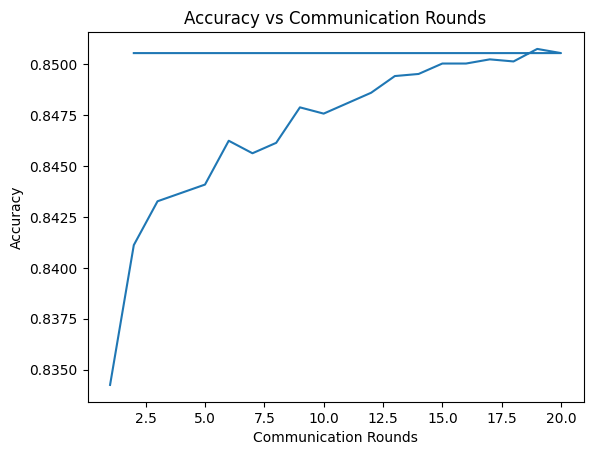

In [ ]:
import matplotlib.pyplot as plt
  
  
# plotting the points 
plt.plot(x_data, y_data)
  
# naming the x axis
plt.xlabel('Communication Rounds')
# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('Accuracy vs Communication Rounds')
  
# function to show the plot
plt.show()